## Train and Export Pipeline

Register custom COCO datasets, setup model from c4_faster_rcnn_fbnetv3a_C4.yaml, run training and export for mobile.

In [1]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("c4_train", {}, "datasets/c4/labels.json", "datasets/c4/clean")
register_coco_instances("c4_train_set2", {}, "datasets/set2/labels_set2.json", "datasets/set2/clean")

/home/tho121/c4project_final/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
register_coco_instances("c4_val1", {}, "datasets/val1/labels_val1.json", "datasets/val1/clean")

In [3]:
import os
from d2go.runner import GeneralizedRCNNRunner
from d2go.model_zoo import model_zoo

def prepare_for_launch():
    runner = GeneralizedRCNNRunner()
    cfg = runner.get_default_cfg()
    cfg.merge_from_file("c4_faster_rcnn_fbnetv3a_C4.yaml")
    cfg.MODEL_EMA.ENABLED = False
    cfg.DATASETS.TRAIN = ("c4_train","c4_train_set2")
    cfg.DATASETS.TEST = ("c4_val1",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = None #model_zoo.get_checkpoint_url("faster_rcnn_fbnetv3a_C4.yaml")  # Let training initialize from model zoo
    cfg.MODEL.DEVICE = "cpu" if ('CI' in os.environ) else "cuda"
    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.SOLVER.BASE_LR = 0.03  # pick a good LR
    cfg.SOLVER.MAX_ITER = 50000    # 600 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.SOLVER.OPTIMIZER = 'adamw_mt'
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    return cfg, runner

In [4]:
import torch
if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [5]:
cfg, runner = prepare_for_launch()
model = runner.build_model(cfg)
#model.load_state_dict(torch.load("output_2/model_final.pth")['model'])

INFO:d2go.modeling.backbone.fbnet_v2:Using un-unified arch_def for ARCH "FBNetV3_A_dsmask" (without scaling):
trunk
- [('conv_k3', 16, 2, 1), ('ir_k3', 16, 1, 1, {'expansion': 1}, {'less_se_channels': False})]
- [('ir_k5', 32, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5', 32, 1, 1, {'expansion': 2}, {'less_se_channels': False})]
- [('ir_k5', 40, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3', 40, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5', 72, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3', 72, 1, 3, {'expansion': 3}, {'less_se_channels': False}), ('ir_k5', 112, 1, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5', 112, 1, 3, {'expansion': 4}, {'less_se_channels': False})]
rpn
- [('ir_k5', 112, 1, 3, {'expansion': 4}, {'less_se_channels': False})]
bbox
- [('ir_k3', 128, 2, 1, {'expansion': 4}), ('ir_k3', 128, 1, 2, {'expansion': 6}), ('ir_k3', 160, 1, 1, {'expansion': 6})]
mask
- [('ir_k3', 128, 2, 1, {'

In [6]:
runner.do_train(cfg, model, resume=False)

INFO:d2go.optimizer.build:Using optimizer:
NewCls (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: True
    lr: 0.03
    maximize: False
    weight_decay: 0.0001

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: True
    lr: 0.03
    maximize: False
    weight_decay: 0.0
)
INFO:d2go.optimizer.build:optimizer parameter groups:
Param group 0: {amsgrad: False, betas: (0.9, 0.999), capturable: False, eps: 1e-08, foreach: True, lr: 0.03, maximize: False, params: 75, weight_decay: 0.0001}
Param group 1: {amsgrad: False, betas: (0.9, 0.999), capturable: False, eps: 1e-08, foreach: True, lr: 0.03, maximize: False, params: 88, weight_decay: 0.0}

INFO:fvcore.common.checkpoint:No checkpoint found. Initializing model from scratch
INFO:d2go.data.build:Building D2Go's train loader ...
INFO:d2go.data.build:Using dataset mapper:
D2GoDatasetMapper:
  is_train: True
  image_load

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.841
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.995
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.853
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.866
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.299
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.873
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.811
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.873
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 5:01:12  iter: 5019  total_loss: 0.3177  loss_cls: 0.04192  loss_box_reg: 0.1561  loss_rpn_cls: 0.005504  loss_rpn_loc: 0.1056  time: 0.4072  data_time: 0.0866  lr: 0.02926  max_mem: 2075M
INFO:detectron2.utils.events: eta: 5:01:13  iter: 5039  total_loss: 0.3725  loss_cls: 0.05655  loss_box_reg: 0.1889  loss_rpn_cls: 0.009472  loss_rpn_loc: 0.1074  time: 0.4072  data_time: 0.0864  lr: 0.029254  max_mem: 2075M
INFO:detectron2.utils.events: eta: 5:00:58  iter: 5059  total_loss: 0.3598  loss_cls: 0.06322  loss_box_reg: 0.1695  loss_rpn_cls: 0.007567  loss_rpn_loc: 0.1149  time: 0.4072  data_time: 0.0799  lr: 0.029249  max_mem: 2075M
INFO:detectron2.utils.events: eta: 5:01:25  iter: 5079  total_loss: 0.3306  loss_cls: 0.05281  loss_box_reg: 0.1611  loss_rpn_cls: 0.005384  loss_rpn_loc: 0.1126  time: 0.4073  data_time: 0.0848  lr: 0.029243  max_mem: 2075M
INFO:detectron2.utils.events: eta: 5:01:44  iter: 5099  total_loss: 0.3338  loss_cls: 0.04816  loss_b

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.852
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.964
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.961
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.852
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.902
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.881
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.876
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 4:20:41  iter: 10019  total_loss: 0.2856  loss_cls: 0.04368  loss_box_reg: 0.1298  loss_rpn_cls: 0.006603  loss_rpn_loc: 0.1048  time: 0.4099  data_time: 0.0736  lr: 0.027125  max_mem: 2075M
INFO:detectron2.utils.events: eta: 4:20:01  iter: 10039  total_loss: 0.2686  loss_cls: 0.0433  loss_box_reg: 0.124  loss_rpn_cls: 0.005898  loss_rpn_loc: 0.09692  time: 0.4099  data_time: 0.0776  lr: 0.027114  max_mem: 2075M
INFO:detectron2.utils.events: eta: 4:18:50  iter: 10059  total_loss: 0.2723  loss_cls: 0.03774  loss_box_reg: 0.1262  loss_rpn_cls: 0.007075  loss_rpn_loc: 0.09549  time: 0.4098  data_time: 0.0770  lr: 0.027102  max_mem: 2075M
INFO:detectron2.utils.events: eta: 4:18:16  iter: 10079  total_loss: 0.2656  loss_cls: 0.0409  loss_box_reg: 0.1191  loss_rpn_cls: 0.006506  loss_rpn_loc: 0.09829  time: 0.4098  data_time: 0.0751  lr: 0.027091  max_mem: 2075M
INFO:detectron2.utils.events: eta: 4:18:05  iter: 10099  total_loss: 0.2681  loss_cls: 0.03657  

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.778
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.868
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.932
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.787
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.800
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.897
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 3:55:06  iter: 15019  total_loss: 0.2071  loss_cls: 0.03041  loss_box_reg: 0.1008  loss_rpn_cls: 0.002891  loss_rpn_loc: 0.07275  time: 0.4097  data_time: 0.0794  lr: 0.023802  max_mem: 2075M
INFO:detectron2.utils.events: eta: 3:55:00  iter: 15039  total_loss: 0.2055  loss_cls: 0.03363  loss_box_reg: 0.09582  loss_rpn_cls: 0.002944  loss_rpn_loc: 0.07106  time: 0.4097  data_time: 0.0833  lr: 0.023787  max_mem: 2075M
INFO:detectron2.utils.events: eta: 3:55:04  iter: 15059  total_loss: 0.1917  loss_cls: 0.03066  loss_box_reg: 0.09423  loss_rpn_cls: 0.003407  loss_rpn_loc: 0.06547  time: 0.4097  data_time: 0.0832  lr: 0.023772  max_mem: 2075M
INFO:detectron2.utils.events: eta: 3:55:28  iter: 15079  total_loss: 0.2046  loss_cls: 0.03309  loss_box_reg: 0.1006  loss_rpn_cls: 0.002059  loss_rpn_loc: 0.06254  time: 0.4097  data_time: 0.0911  lr: 0.023756  max_mem: 2075M
INFO:detectron2.utils.events: eta: 3:55:23  iter: 15099  total_loss: 0.1981  loss_cls: 0.0

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.866
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.857
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.926
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.896
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.888
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 3:21:15  iter: 20019  total_loss: 0.1727  loss_cls: 0.02645  loss_box_reg: 0.08105  loss_rpn_cls: 0.001794  loss_rpn_loc: 0.0647  time: 0.4110  data_time: 0.0772  lr: 0.019618  max_mem: 2075M
INFO:detectron2.utils.events: eta: 3:21:02  iter: 20039  total_loss: 0.1655  loss_cls: 0.02056  loss_box_reg: 0.07935  loss_rpn_cls: 0.001581  loss_rpn_loc: 0.05921  time: 0.4109  data_time: 0.0789  lr: 0.0196  max_mem: 2075M
INFO:detectron2.utils.events: eta: 3:20:42  iter: 20059  total_loss: 0.1675  loss_cls: 0.02408  loss_box_reg: 0.07771  loss_rpn_cls: 0.001676  loss_rpn_loc: 0.06374  time: 0.4109  data_time: 0.0785  lr: 0.019582  max_mem: 2075M
INFO:detectron2.utils.events: eta: 3:20:42  iter: 20079  total_loss: 0.156  loss_cls: 0.02459  loss_box_reg: 0.07522  loss_rpn_cls: 0.001715  loss_rpn_loc: 0.05402  time: 0.4109  data_time: 0.0808  lr: 0.019564  max_mem: 2075M
INFO:detectron2.utils.events: eta: 3:20:42  iter: 20099  total_loss: 0.1685  loss_cls: 0.024

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.885
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.885
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.928
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.789
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.911
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.816
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.909
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 2:48:21  iter: 25019  total_loss: 0.1171  loss_cls: 0.01645  loss_box_reg: 0.05771  loss_rpn_cls: 0.000565  loss_rpn_loc: 0.0418  time: 0.4116  data_time: 0.0785  lr: 0.014982  max_mem: 2075M
INFO:detectron2.utils.events: eta: 2:48:31  iter: 25039  total_loss: 0.1052  loss_cls: 0.01472  loss_box_reg: 0.05153  loss_rpn_cls: 0.0005313  loss_rpn_loc: 0.03749  time: 0.4116  data_time: 0.0869  lr: 0.014963  max_mem: 2075M
INFO:detectron2.utils.events: eta: 2:48:26  iter: 25059  total_loss: 0.1004  loss_cls: 0.01394  loss_box_reg: 0.05226  loss_rpn_cls: 0.0004327  loss_rpn_loc: 0.03691  time: 0.4116  data_time: 0.0861  lr: 0.014944  max_mem: 2075M
INFO:detectron2.utils.events: eta: 2:48:22  iter: 25079  total_loss: 0.1062  loss_cls: 0.01541  loss_box_reg: 0.05344  loss_rpn_cls: 0.0006526  loss_rpn_loc: 0.03734  time: 0.4116  data_time: 0.0864  lr: 0.014926  max_mem: 2075M
INFO:detectron2.utils.events: eta: 2:48:16  iter: 25099  total_loss: 0.1194  loss_cls:

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.958
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.798
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.921
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.907
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 2:15:11  iter: 30019  total_loss: 0.08571  loss_cls: 0.01219  loss_box_reg: 0.04242  loss_rpn_cls: 0.0002001  loss_rpn_loc: 0.03125  time: 0.4125  data_time: 0.1086  lr: 0.010348  max_mem: 2075M
INFO:detectron2.utils.events: eta: 2:14:58  iter: 30039  total_loss: 0.0882  loss_cls: 0.0131  loss_box_reg: 0.0424  loss_rpn_cls: 0.0001997  loss_rpn_loc: 0.0305  time: 0.4126  data_time: 0.1152  lr: 0.01033  max_mem: 2075M
INFO:detectron2.utils.events: eta: 2:14:45  iter: 30059  total_loss: 0.0832  loss_cls: 0.0104  loss_box_reg: 0.04079  loss_rpn_cls: 0.0002996  loss_rpn_loc: 0.0322  time: 0.4126  data_time: 0.0949  lr: 0.010312  max_mem: 2075M
INFO:detectron2.utils.events: eta: 2:14:43  iter: 30079  total_loss: 0.08645  loss_cls: 0.01156  loss_box_reg: 0.04444  loss_rpn_cls: 0.0003177  loss_rpn_loc: 0.03238  time: 0.4127  data_time: 0.1077  lr: 0.010294  max_mem: 2075M
INFO:detectron2.utils.events: eta: 2:14:40  iter: 30099  total_loss: 0.08771  loss_cls: 

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.904
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.982
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.795
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.880
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.959
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.803
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.926
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.818
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.910
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 1:36:08  iter: 35019  total_loss: 0.06315  loss_cls: 0.008141  loss_box_reg: 0.03347  loss_rpn_cls: 0.0001182  loss_rpn_loc: 0.02215  time: 0.4141  data_time: 0.0763  lr: 0.0061687  max_mem: 2075M
INFO:detectron2.utils.events: eta: 1:36:06  iter: 35039  total_loss: 0.06375  loss_cls: 0.007653  loss_box_reg: 0.03289  loss_rpn_cls: 8.82e-05  loss_rpn_loc: 0.02264  time: 0.4141  data_time: 0.0752  lr: 0.0061535  max_mem: 2075M
INFO:detectron2.utils.events: eta: 1:35:59  iter: 35059  total_loss: 0.06407  loss_cls: 0.008089  loss_box_reg: 0.03309  loss_rpn_cls: 8.651e-05  loss_rpn_loc: 0.02153  time: 0.4141  data_time: 0.0771  lr: 0.0061383  max_mem: 2075M
INFO:detectron2.utils.events: eta: 1:35:51  iter: 35079  total_loss: 0.06054  loss_cls: 0.007207  loss_box_reg: 0.03073  loss_rpn_cls: 0.0001548  loss_rpn_loc: 0.02314  time: 0.4140  data_time: 0.0754  lr: 0.0061231  max_mem: 2075M
INFO:detectron2.utils.events: eta: 1:35:45  iter: 35099  total_loss: 0.06

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.908
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.791
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.960
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.931
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.917
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 1:02:25  iter: 40019  total_loss: 0.0447  loss_cls: 0.006092  loss_box_reg: 0.02411  loss_rpn_cls: 6.71e-05  loss_rpn_loc: 0.01577  time: 0.4117  data_time: 0.0727  lr: 0.0028542  max_mem: 2075M
INFO:detectron2.utils.events: eta: 1:02:19  iter: 40039  total_loss: 0.04712  loss_cls: 0.005495  loss_box_reg: 0.02402  loss_rpn_cls: 7.912e-05  loss_rpn_loc: 0.01684  time: 0.4117  data_time: 0.0740  lr: 0.0028432  max_mem: 2075M
INFO:detectron2.utils.events: eta: 1:02:15  iter: 40059  total_loss: 0.04789  loss_cls: 0.006084  loss_box_reg: 0.02447  loss_rpn_cls: 7.854e-05  loss_rpn_loc: 0.0164  time: 0.4117  data_time: 0.0758  lr: 0.0028321  max_mem: 2075M
INFO:detectron2.utils.events: eta: 1:02:08  iter: 40079  total_loss: 0.04425  loss_cls: 0.005435  loss_box_reg: 0.02368  loss_rpn_cls: 6.974e-05  loss_rpn_loc: 0.0158  time: 0.4117  data_time: 0.0764  lr: 0.0028211  max_mem: 2075M
INFO:detectron2.utils.events: eta: 1:02:07  iter: 40099  total_loss: 0.04611

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.783
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.897
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.960
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.804
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.930
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.916
 Average Recall     (AR) @[ IoU=0.50:0.

INFO:detectron2.utils.events: eta: 0:31:09  iter: 45019  total_loss: 0.03691  loss_cls: 0.003458  loss_box_reg: 0.01927  loss_rpn_cls: 2.578e-05  loss_rpn_loc: 0.01294  time: 0.4087  data_time: 0.0723  lr: 0.00072863  max_mem: 2075M
INFO:detectron2.utils.events: eta: 0:31:01  iter: 45039  total_loss: 0.03514  loss_cls: 0.003267  loss_box_reg: 0.01846  loss_rpn_cls: 3.875e-05  loss_rpn_loc: 0.01364  time: 0.4087  data_time: 0.0743  lr: 0.00072284  max_mem: 2075M
INFO:detectron2.utils.events: eta: 0:30:54  iter: 45059  total_loss: 0.0347  loss_cls: 0.003011  loss_box_reg: 0.0183  loss_rpn_cls: 2.916e-05  loss_rpn_loc: 0.01234  time: 0.4087  data_time: 0.0694  lr: 0.00071707  max_mem: 2075M
INFO:detectron2.utils.events: eta: 0:30:46  iter: 45079  total_loss: 0.03478  loss_cls: 0.003481  loss_box_reg: 0.01861  loss_rpn_cls: 3.34e-05  loss_rpn_loc: 0.01262  time: 0.4087  data_time: 0.0720  lr: 0.00071132  max_mem: 2075M
INFO:detectron2.utils.events: eta: 0:30:39  iter: 45099  total_loss: 0.

{'model_final': CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': './output/model_final.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'FBNetV2C4Backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': [], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[16, 32, 64, 96, 128, 160]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'FBNetV2RpnHead', 'IN_FEATURES': ['trunk3'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1', 'BBOX_REG_LOSS_WEIGHT': 1.0, 'BBOX_REG_WEIGHTS': (1.0, 1.0, 1.0, 

In [7]:
metrics = runner.do_test(cfg, model)

INFO:d2go.runner.default_runner:Running evaluation for model tag default at iter None...
INFO:d2go.runner.default_runner:Building detection test loader for dataset: c4_val1 ...
INFO:d2go.runner.default_runner:Using dataset mapper:
D2GoDatasetMapper:
  is_train: False
  image_loader: None
  tfm_gens: 

INFO:detectron2.data.datasets.coco:Loaded 25 images in COCO format from datasets/val1/labels_val1.json
INFO:detectron2.data.common:Serializing the dataset using: <class 'mobile_cv.torch.utils_pytorch.shareables.SharedList'>
INFO:mobile_cv.torch.utils_pytorch.shareables:Serializing 25 elements to byte tensors and concatenating them all ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Serialized dataset takes 0.03 MiB
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving serialized dataset to shared memory ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving data to shared memory (SharedMemory('psm_03e89b8f', size=35498)) ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving data to 

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.909
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.965
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.332
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.806
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.932
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.809
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.928
 Average Recall     (AR) @[ IoU=0.50:0.

Create predictor, to be used in exporting

In [8]:
import torch

class C4Predictor:
    def __init__(self, model, min_size_test=384, max_size_test=510, input_format="RGB"):
        self.model = model
        self.model.eval()

        #self.aug = []#T.ResizeShortestEdge([min_size_test, min_size_test], max_size_test)

        self.input_format = input_format

    def __call__(self, original_image):

        inputs = self.convert_input(original_image)
        predictions = self.model([inputs])[0]
        return predictions

    def convert_input(self, original_image):
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            #image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}

            return inputs

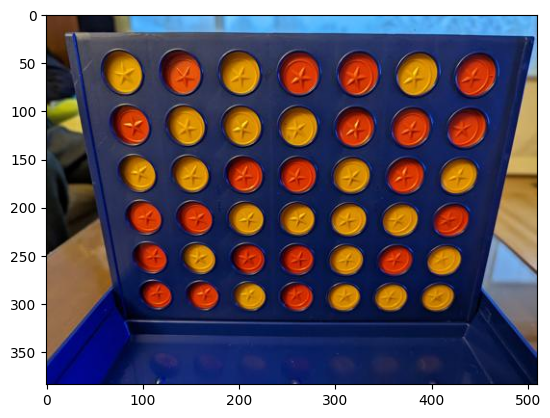

In [12]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

im = Image.open("datasets/val1/clean/c4_val1_8.jpg")
plt.imshow(im)

In [13]:
import numpy as np
predictor = C4Predictor(model, min_size_test=384, max_size_test=510)
outputs = predictor(np.array(im))
# the output object categories and corresponding bounding boxes
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2,
        3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 2, 0, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2,
        3, 2, 2, 3], device='cuda:0')
Boxes(tensor([[389.7463,  35.9516, 469.1516, 308.0343],
        [289.6173,  35.5632, 347.8693, 313.5552],
        [178.9186,  39.6907, 231.7598, 313.3855],
        [238.2515,  37.2907, 286.7305, 311.6627],
        [340.5430,  34.2188, 409.4010, 311.9509],
        [ 57.1211,  43.6220, 133.6172, 308.0727],
        [116.9389,  37.2289, 181.2537, 312.3612],
        [178.6326,  36.9640, 225.9023,  88.2778],
        [406.8815, 146.8531, 452.5062, 189.3650],
        [359.6061,  37.2261, 408.5468,  88.8481],
        [295.7169, 146.3941, 340.2374, 188.3134],
        [138.9602, 235.7875, 177.0586, 270.9490],
        [187.1489, 193.2233, 228.9247, 230.4191],
        [347.4402, 194.6997, 389.1419, 232.5610],
        [401.4600, 194.8885, 442.3453, 233.7008],
        [415.1987,  96.3678, 461.0830, 141.414

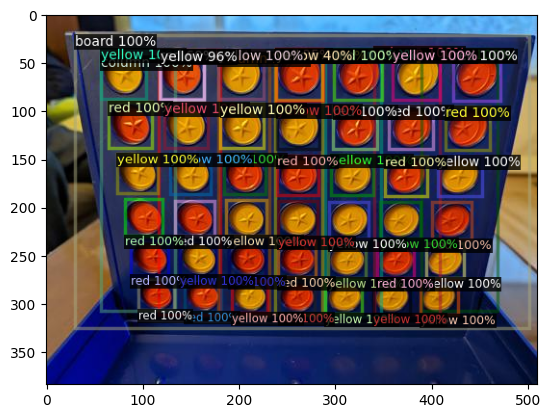

In [14]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

v = Visualizer(im, MetadataCatalog.get("c4_train"))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())

Setup wrapper for mobile model exporting

In [17]:
import contextlib
import copy
import os
import unittest
from PIL import Image

import torch
from d2go.export.exporter import convert_and_export_predictor
#from d2go.export.d2_meta_arch import patch_d2_meta_arch
from d2go.runner import create_runner, GeneralizedRCNNRunner
from d2go.model_zoo import model_zoo

from mobile_cv.common.misc.file_utils import make_temp_directory
from d2go.utils.testing.data_loader_helper import LocalImageGenerator, register_toy_coco_dataset
from torch.utils.mobile_optimizer import optimize_for_mobile

#patch_d2_meta_arch()


@contextlib.contextmanager
def create_fake_detection_data_loader(height, width, is_train):
    with make_temp_directory("detectron2go_tmp_dataset") as dataset_dir:
        cfg, runner = prepare_for_launch()
        #model = runner.build_model(cfg)
        cfg.DATASETS.TRAIN = ["c4_train"]
        cfg.DATASETS.TEST = ["c4_val"]

        if is_train:
            with register_toy_coco_dataset(
                "c4_train_fake", num_images=3
            ):
                train_loader = runner.build_detection_train_loader(cfg)
                yield train_loader
        else:
            with register_toy_coco_dataset(
                "c4_val_fake", num_images=3
            ):
                test_loader = runner.build_detection_test_loader(
                    cfg, dataset_name="c4_val"
                )
                yield test_loader

def test_export_torchvision_format(model):
    cfg_name = 'c4_faster_rcnn_fbnetv3a_C4.yaml'
    pytorch_model = model #model_zoo.get(cfg_name, trained=True)

    from typing import List, Dict
    class Wrapper(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            coco_idx_list = [1, 2, 3, 4, 5]

            self.coco_idx = torch.tensor(coco_idx_list)

        def forward(self, inputs: List[torch.Tensor]):
            x = inputs[0].unsqueeze(0) # * 255
            #scale = 1.0 #320.0 / min(x.shape[-2], x.shape[-1])
            #x = torch.nn.functional.interpolate(x, scale_factor=scale, mode="bilinear", align_corners=True, recompute_scale_factor=True)
            out = self.model(x[0])
            res : Dict[str, torch.Tensor] = {}
            res["boxes"] = out[0]
            res["labels"] = torch.index_select(self.coco_idx, 0, out[1])
            res["scores"] = out[2]
            return inputs, [res]

    #size_divisibility = max(pytorch_model.backbone.size_divisibility, 10)
    h, w = (384,510)#size_divisibility, size_divisibility * 2
    with create_fake_detection_data_loader(h, w, is_train=False) as data_loader:
        cfg, runner = prepare_for_launch()
        predictor_path = convert_and_export_predictor(
            cfg,
            copy.deepcopy(pytorch_model),
            "torchscript_mobile",#"torchscript_int8@tracing",
            './',
            data_loader,
        )

        orig_model = torch.jit.load(os.path.join(predictor_path, "model.jit"))
        wrapped_model = Wrapper(orig_model)
        # optionally do a forward
        wrapped_model([torch.rand(3, 384, 510)])
        scripted_model = torch.jit.script(wrapped_model)
        torch.jit.save(scripted_model, "d2go_scripted.pt")
        optimized_torchscript_model = optimize_for_mobile(scripted_model)
        optimized_torchscript_model._save_for_lite_interpreter("d2go_mobile_opt.ptl")
        #scripted_model.save("d2go_mobile.pt")

Load model parameters here if re-exporting

In [ ]:
#model.load_state_dict(torch.load("/home/tho121/C4Yolo/output_3/model_final.pth")["model"])

In [18]:
model.eval()
test_export_torchvision_format(model.cpu())

INFO:d2go.runner.default_runner:Building detection test loader for dataset: c4_val ...
INFO:d2go.runner.default_runner:Using dataset mapper:
D2GoDatasetMapper:
  is_train: False
  image_loader: None
  tfm_gens: 

INFO:detectron2.data.datasets.coco:Loaded 99 images in COCO format from datasets/c4/labels.json
INFO:detectron2.data.common:Serializing the dataset using: <class 'mobile_cv.torch.utils_pytorch.shareables.SharedList'>
INFO:mobile_cv.torch.utils_pytorch.shareables:Serializing 99 elements to byte tensors and concatenating them all ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Serialized dataset takes 0.14 MiB
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving serialized dataset to shared memory ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving data to shared memory (SharedMemory('psm_110d6d5a', size=145247)) ...
INFO:mobile_cv.torch.utils_pytorch.shareables:Moving data to shared memory (SharedMemory('psm_5ea3aea3', size=792)) ...
INFO:mobile_cv.torch.utils_pytorch.sh